In [19]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [20]:
# Read in csv files, and show all columns when displayed
transactions_data = pd.read_csv('./transactions.csv')
train = pd.read_csv('./train.csv')
pd.options.display.max_columns = None

In [21]:
# get shapes of datasets - caution this cell takes a while to load.
print("transactions_data.shape: ", transactions_data.shape)

# there are 9 columns, 21.5M records

transactions_data.shape:  (21547746, 9)


# Create aggregated datasets for downstream EDA

In [22]:
# group the transactions data up to the member ID level to get count of transactions
transactions_data_count_transactions = transactions_data.groupby(['msno'])[['payment_method_id']].count()

# check the output
transactions_data_count_transactions.head()

,payment_method_id
msno,
+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,1
+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,1
+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,4
+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,19
+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,26


In [23]:
# rename the field for clarity
transactions_data_count_transactions.columns = ['total_transactions']

In [24]:
# create additional aggregated data by finding the average of the features by user
transactions_data_averages = transactions_data.groupby(['msno'])[['payment_plan_days', 'plan_list_price', 'actual_amount_paid', 
                                                                'is_auto_renew', 'is_cancel']].mean()

# check the output
transactions_data_averages.head()

,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel
msno,,,,,
+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,7.000000,0.000000,0.0,0.0,0.0
+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,410.000000,1788.000000,1788.0,0.0,0.0
+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,30.000000,99.000000,99.0,1.0,0.0
+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,28.578947,141.157895,149.0,1.0,0.0
+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,28.846154,143.269231,149.0,1.0,0.0


In [25]:
# QC a particaulr user id to make sure the aggregation worked.
mask = transactions_data.msno == '+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s='
transactions_data[mask]
# this particular msno had only one transaction, which matches the aggregated data above 

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
1521480,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,38,410,1788,1788,0,20151121,20170104,0


In [26]:
# rename column names for clarity:
col_names = ['avg_payment_plan_days', 'avg_plan_list_price', 'avg_actual_amount_paid', 'pct_is_auto_renew', 'pct_is_cancel']
transactions_data_averages.columns = col_names

#check out the column names of the aggregated dataset
transactions_data_averages.columns

Index(['avg_payment_plan_days', 'avg_plan_list_price',
       'avg_actual_amount_paid', 'pct_is_auto_renew', 'pct_is_cancel'],
      dtype='object')

In [27]:
# merge the transaction counts dataframe with the user averages dataframe, using msno as the key
transactions_data_grouped = transactions_data_averages.merge(transactions_data_count_transactions, how='left', on='msno')

In [28]:
# count the number of cancels per user
transactions_data_cancels = transactions_data.groupby(['msno'])[['is_cancel']].sum()

# count the number of cancels per user
transactions_data_autorenew = transactions_data.groupby(['msno'])[['is_auto_renew']].sum()

In [29]:
transactions_data_grouped = transactions_data_grouped.merge(transactions_data_cancels, how='left', on='msno')

In [30]:
transactions_data_grouped = transactions_data_grouped.merge(transactions_data_autorenew, how='left', on='msno')

# EDA on features that aren't aggregated to determine impact on churn

In [31]:
# merge training dataset with raw transaction data 
train = train.merge(transactions_data, how='left', on = 'msno')

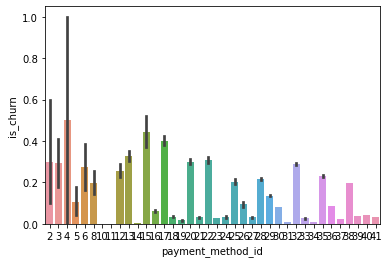

In [32]:
# plot the churn rate by payment method ID. No key is provided on the methods, but we can look at the rates
sns.barplot(data=train, x='payment_method_id', y='is_churn');

# results show that the payment method IDs vary by churn. Let's create a new field with these averages
# for the model, since there are so many methods

In [33]:
# create a payment method ID churn dataframe
payment_method_id_churn_avg = train.groupby(['payment_method_id'])[['is_churn']].mean().reset_index()

# rename column names for clarity
payment_method_id_churn_avg.columns = ['payment_method_id', 'pay_method_id_churn_avg']

# sort the payment methods by churn
payment_method_id_churn_avg = payment_method_id_churn_avg.sort_values(by='pay_method_id_churn_avg', ascending=True)

# show the dataframe
payment_method_id_churn_avg

,payment_method_id,pay_method_id_churn_avg
7,11,0.000000
6,10,0.000000
10,14,0.003257
27,31,0.009722
30,34,0.010315
15,19,0.017533
33,37,0.022520
29,33,0.026189
19,23,0.027904
37,41,0.031462


# Combine derived dataframes and export to csv

In [34]:
# combine average churn with train dataset
payment_method_id_churn_avg_msno = train.merge(payment_method_id_churn_avg, how='left', on = 'payment_method_id')

# trim down dataframe to just the msno and payment method churn average
payment_method_id_churn_avg_msno_final = payment_method_id_churn_avg_msno[['msno', 'pay_method_id_churn_avg']].copy()

In [35]:
# combine the aggregated dataset with the payment method churn average
transactions_data_grouped = transactions_data_grouped.merge(payment_method_id_churn_avg_msno_final, how='left', on='msno')

In [36]:
# show the headers and the first few records
transactions_data_grouped.head()

,msno,avg_payment_plan_days,avg_plan_list_price,avg_actual_amount_paid,pct_is_auto_renew,pct_is_cancel,total_transactions,is_cancel,is_auto_renew,pay_method_id_churn_avg
0,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,7.0,0.0,0.0,0.0,0.0,1,0,0,NaN
1,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,410.0,1788.0,1788.0,0.0,0.0,1,0,0,NaN
2,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,30.0,99.0,99.0,1.0,0.0,4,0,4,0.031462
3,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,30.0,99.0,99.0,1.0,0.0,4,0,4,0.031462
4,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,30.0,99.0,99.0,1.0,0.0,4,0,4,0.031462


In [37]:
# output the grouped data for downstream merging and further EDA
transactions_data_grouped.to_csv(path_or_buf='./transactions_grouped.csv')